# Copyright

<PRE>
This notebook was created as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19
using
https://www.scaler.com/topics/pytorch/build-and-train-an-image-classification-model-with-pytorch-lightning/

Any re-use or publication of any part of the notebook is only allowed with the
 written consent of the authors.

2024 (c) Mohammed Salah Al-Radhi, Tamás Gábor Csapó
</PRE>

In [21]:
!pip install pytorch-lightning --quiet

## To not show the logs , use quiet

In [22]:
import pytorch_lightning as pl

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader

from torchmetrics import Accuracy

from torchvision import transforms
from torchvision.datasets import CIFAR10

Files already downloaded and verified


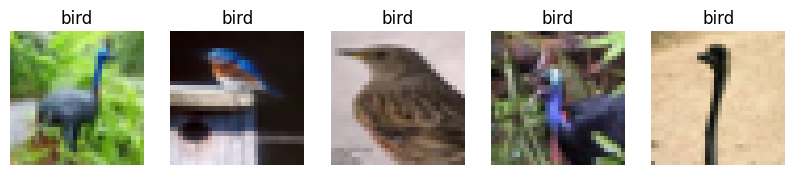

In [36]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Define the transform to convert images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the CIFAR-10 training dataset
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Class names in CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for i, image in enumerate(images):
        axes[i].imshow(image.permute(1, 2, 0))  # Rearrange dimensions for plotting (C, H, W) -> (H, W, C)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

# Get a batch of bird images
bird_images = []
bird_labels = []
for i in range(len(cifar10)):
    image, label = cifar10[i]
    if classes[label] == 'bird':  # Check if the label corresponds to 'bird'
        bird_images.append(image)
        bird_labels.append(label)
    if len(bird_images) == 5:  # Display 5 bird images
        break

# Show the bird images
show_images(bird_images, bird_labels)


In [42]:
class CIFAR10DataModule(pl.LightningDataModule):
    '''organize the data pipeline from accessing the data to loading it using PyTorch dataloaders'''


    def __init__(self, batch_size, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            # Randomly flipping images horizontally
            transforms.RandomHorizontalFlip(),
            ## Randomly rotating input images
            transforms.RandomRotation(5), # Rotating by 5 degrees say -5 to 5
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.dims = (3, 32, 32)
        self.num_classes = 10

    def prepare_data(self):
        # download the CIFAR-10 dataset
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    # PyTorch dataset instances
    def setup(self, stage=None):

        if stage == 'fit' or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        if stage == 'test' or stage is None:
            self.cifar_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    # dataloaders
    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=self.batch_size)

In [43]:
class CIFARLitModel(pl.LightningModule):
    '''model architecture, training, testing and validation loops'''
    def __init__(self, input_shape, num_classes, learning_rate=3e-4):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        # model architecture
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32) ## To stabilize learning and faster convergence

        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.bn4 = nn.BatchNorm2d(64)

        self.pool1 = torch.nn.MaxPool2d(2)
        self.pool2 = torch.nn.MaxPool2d(2)

        n_sizes = self._get_output_shape(input_shape)

        # linear layers for classifier head
        self.fc1 = nn.Linear(n_sizes, 512)

        # Tweaking as per the next linear input size
        self.fc2 = nn.Linear(512, 256)

        ## Adding the new layer as mentioned
        self.fc_new = nn.Linear(256, 128)

        ## Dropout layer
        self.dropout = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, num_classes)

        self.accuracy = Accuracy(task="multiclass", num_classes=10)

    def _get_output_shape(self, shape):
        '''returns the size of the output tensor from the conv layers'''

        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._feature_extractor(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # computations
    def _feature_extractor(self, x):
        '''extract features from the conv blocks'''
        x = F.relu(self.bn1(self.conv1(x)))  # Apply BatchNorm after Conv1
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))  # Apply BatchNorm after Conv2
        x = F.relu(self.bn3(self.conv3(x)))  # Apply BatchNorm after Conv3
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))  # Apply BatchNorm after Conv4
        return x

    def forward(self, x):
       ##produce final model output
       x = self._feature_extractor(x)
       x = x.view(x.size(0), -1)

       x = F.relu(self.fc1(x))
       x = self.dropout(x)  # Applied dropout

       x = F.relu(self.fc2(x))
       ## Cancelling droput
       ## x = self.dropout(x)

       x = F.relu(self.fc_new(x))
       ## Cancelling dropout
       ## x = self.dropout(x)

       x = F.log_softmax(self.fc3(x), dim=1)
       return x

    # train loop
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # metric
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        return loss

    # validation loop
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    # test loop
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    # optimizers
    def configure_optimizers(self):
        ## Using AdamW with weight decay
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-3)

        ## Schedule the learning rate; Initially have higher learning rate and gradually decrease,
        ## similar to gradient descent concept
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1),
            'interval': 'epoch',  # Update the scheduler at the end of each epoch
            'frequency': 1,
        }

        return [optimizer], [scheduler]

In [44]:
# instantiate classes
dm = CIFAR10DataModule(batch_size=32)
dm.prepare_data()
dm.setup()
model = CIFARLitModel((3, 32, 32), dm.num_classes)

Files already downloaded and verified
Files already downloaded and verified


In [45]:
# Initialize Callbacks
checkpoint_callback = pl.callbacks.ModelCheckpoint()
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_acc", patience=5, verbose=True, mode="max")
trainer = pl.Trainer(max_epochs=12,
                     callbacks=[checkpoint_callback, early_stop_callback]
                    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [46]:
# Train the model
trainer.fit(model, dm)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name     | Type               | Params | Mode 
---------------------------------------------------------
0  | conv1    | Conv2d             | 896    | train
1  | bn1      | BatchNorm2d        | 64     | train
2  | conv2    | Conv2d             | 9.2 K  | train
3  | bn2      | BatchNorm2d        | 64     | train
4  | conv3    | Conv2d             | 18.5 K | train
5  | bn3      | BatchNorm2d        | 128    | train
6  | conv4    | Conv2d             | 36.9 K | train
7  | bn4      | BatchNorm2d        | 128    | train
8  | pool1    | MaxPool2d          | 0      | train
9  | pool2    | MaxPool2d          | 0      | train
10 | fc1      | Linear             | 819 K  | train
11 | fc2      | Linear             | 131 K  | train
12 | fc_new   | Linear             | 32.9 K | train
13 | dropout  | Dropout            | 0      | train
14 | fc3      | Linear         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.623


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.049 >= min_delta = 0.0. New best score: 0.672


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.039 >= min_delta = 0.0. New best score: 0.711


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.712


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.045 >= min_delta = 0.0. New best score: 0.757


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.022 >= min_delta = 0.0. New best score: 0.779


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.781


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.013 >= min_delta = 0.0. New best score: 0.793


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.797


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.026 >= min_delta = 0.0. New best score: 0.823


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.824
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=12` reached.


In [47]:
# Evaluate the model
trainer.test(dataloaders=dm.test_dataloader())

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_5/checkpoints/epoch=11-step=16884.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_5/checkpoints/epoch=11-step=16884.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8198000192642212     │
│         test_loss         │    0.5333771705627441     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5333771705627441, 'test_acc': 0.8198000192642212}]

In [ ]:
### TASK OF THE STUDENT
# run the above code on Colab with a GPU,
# add another fully connected (nn.Linear) layer to the network with 256 neurons

In [17]:
# Improvements which was tried

## 1. Diversified the input training samples by rotating or flipping the images
## 2. Increased the number of filters in conv layer
## 3. Dropout layer added after first conv to prevent overfitting
## 4. Batch Normalisation implement for faster convergence
## 5. AdamW used as new optimiser
## 6. Training epochs from 10 to 12